In [0]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("ECommerceAnalysis").getOrCreate()
from pyspark.sql.functions import col, month
from pyspark.sql.functions import col, sum, avg, desc



In [0]:
customers_df = spark.read.csv("/FileStore/tables/customers.csv", header=True,
inferSchema=True)
products_df = spark.read.csv("/FileStore/tables/products.csv", header=True,
inferSchema=True)
orders_df = spark.read.csv("/FileStore/tables/orders.csv", header=True,
inferSchema=True)

In [0]:
display(customers_df)
display(products_df)
display(orders_df)

customer_id,name,city,age
1,Rahul Sharma,Bangalore,28
2,Priya Singh,Delhi,32
3,Aman Kumar,Hyderabad,25
4,Sneha Reddy,Chennai,35
5,Arjun Mehta,Mumbai,30
6,Divya Nair,Delhi,29


product_id,product_name,category,price
101,Laptop,Electronics,55000
102,Mobile,Electronics,25000
103,Headphones,Electronics,3000
104,Chair,Furniture,5000
105,Book,Stationery,700
106,Shoes,Fashion,2500


order_id,customer_id,product_id,quantity,order_date
1001,1,101,1,2024-01-10
1002,2,102,2,2024-01-12
1003,1,103,3,2024-02-05
1004,3,104,1,2024-02-08
1005,5,105,5,2024-03-01
1006,6,106,2,2024-03-15
1007,7,101,1,2024-03-20


In [0]:
joined_df = orders_df.join(products_df, "product_id")
orders_total_df = joined_df.withColumn("total_price", joined_df.quantity *
joined_df.price)
display(orders_total_df)

product_id,order_id,customer_id,quantity,order_date,product_name,category,price,total_price
101,1001,1,1,2024-01-10,Laptop,Electronics,55000,55000
102,1002,2,2,2024-01-12,Mobile,Electronics,25000,50000
103,1003,1,3,2024-02-05,Headphones,Electronics,3000,9000
104,1004,3,1,2024-02-08,Chair,Furniture,5000,5000
105,1005,5,5,2024-03-01,Book,Stationery,700,3500
106,1006,6,2,2024-03-15,Shoes,Fashion,2500,5000
101,1007,7,1,2024-03-20,Laptop,Electronics,55000,55000


In [0]:
high_value_orders = orders_total_df.filter(col("total_price") > 40000)

orders_with_month = high_value_orders.withColumn("month", month(col("order_date")))

sorted_orders = orders_with_month.orderBy(col("total_price").desc())

display(sorted_orders)

product_id,order_id,customer_id,quantity,order_date,product_name,category,price,total_price,month
101,1001,1,1,2024-01-10,Laptop,Electronics,55000,55000,1
101,1007,7,1,2024-03-20,Laptop,Electronics,55000,55000,3
102,1002,2,2,2024-01-12,Mobile,Electronics,25000,50000,1


In [0]:
orders_total_df = (
    orders_df
    .join(customers_df, "customer_id")
    .join(products_df, "product_id")
    .withColumn("total_price", col("quantity") * col("price"))
)


revenue_per_city = (
    orders_total_df.groupBy("city")
    .agg(sum(col("total_price")).alias("total_revenue"))
)
display(revenue_per_city)

avg_age_per_city = (
    customers_df.groupBy("city")
    .agg(avg(col("age")).alias("avg_age"))
)
display(avg_age_per_city)

revenue_per_category = (
    orders_total_df.groupBy("category")
    .agg(sum(col("total_price")).alias("total_revenue"))
)
display(revenue_per_category)

top_customers = (
    orders_total_df.groupBy("customer_id", "name", "city")
    .agg(sum(col("total_price")).alias("total_spent"))
    .orderBy(desc("total_spent"))
    .limit(3)
)
display(top_customers)

city,total_revenue
Bangalore,64000
Mumbai,3500
Delhi,55000
Hyderabad,5000


city,avg_age
Bangalore,28.0
Chennai,35.0
Mumbai,30.0
Delhi,30.5
Hyderabad,25.0


category,total_revenue
Stationery,3500
Fashion,5000
Electronics,114000
Furniture,5000


customer_id,name,city,total_spent
1,Rahul Sharma,Bangalore,64000
2,Priya Singh,Delhi,50000
3,Aman Kumar,Hyderabad,5000


In [0]:
inner_join_df = orders_df.join(customers_df, "customer_id", "inner")
display(inner_join_df)

left_join_df = customers_df.join(orders_df, "customer_id", "left")
display(left_join_df)

right_join_df = orders_df.join(products_df, "product_id", "right")
display(right_join_df)

customer_id,order_id,product_id,quantity,order_date,name,city,age
1,1001,101,1,2024-01-10,Rahul Sharma,Bangalore,28
2,1002,102,2,2024-01-12,Priya Singh,Delhi,32
1,1003,103,3,2024-02-05,Rahul Sharma,Bangalore,28
3,1004,104,1,2024-02-08,Aman Kumar,Hyderabad,25
5,1005,105,5,2024-03-01,Arjun Mehta,Mumbai,30
6,1006,106,2,2024-03-15,Divya Nair,Delhi,29


customer_id,name,city,age,order_id,product_id,quantity,order_date
1,Rahul Sharma,Bangalore,28,1003,103,3,2024-02-05
6,Divya Nair,Delhi,29,1006,106,2,2024-03-15
3,Aman Kumar,Hyderabad,25,1004,104,1,2024-02-08
5,Arjun Mehta,Mumbai,30,1005,105,5,2024-03-01
4,Sneha Reddy,Chennai,35,null,null,null,null
2,Priya Singh,Delhi,32,1002,102,2,2024-01-12
1,Rahul Sharma,Bangalore,28,1001,101,1,2024-01-10


product_id,order_id,customer_id,quantity,order_date,product_name,category,price
101,1007,7,1,2024-03-20,Laptop,Electronics,55000
103,1003,1,3,2024-02-05,Headphones,Electronics,3000
102,1002,2,2,2024-01-12,Mobile,Electronics,25000
105,1005,5,5,2024-03-01,Book,Stationery,700
106,1006,6,2,2024-03-15,Shoes,Fashion,2500
104,1004,3,1,2024-02-08,Chair,Furniture,5000
101,1001,1,1,2024-01-10,Laptop,Electronics,55000


In [0]:
customers_no_orders = customers_df.join(orders_df, "customer_id", "left_anti")
display(customers_no_orders)

products_never_ordered = products_df.join(orders_df, "product_id", "left_anti")
display(products_never_ordered)

customer_id,name,city,age
4,Sneha Reddy,Chennai,35


product_id,product_name,category,price


In [0]:
customers_df.createOrReplaceTempView("customers")
products_df.createOrReplaceTempView("products")
orders_total_df.createOrReplaceTempView("orders")

spark.sql("""
    SELECT city, SUM(total_price) AS total_revenue
    FROM orders
    GROUP BY city
    ORDER BY total_revenue DESC
    LIMIT 2
""").show()

spark.sql("""
    SELECT category, SUM(total_price) AS total_revenue
    FROM orders
    GROUP BY category
    ORDER BY total_revenue DESC
    LIMIT 1
""").show()

spark.sql("""
    SELECT customer_id, name, city, SUM(total_price) AS total_spent
    FROM orders
    GROUP BY customer_id, name, city
    HAVING SUM(total_price) > 50000
""").show()

spark.sql("""
    SELECT MONTH(order_date) AS month, SUM(total_price) AS total_revenue
    FROM orders
    GROUP BY MONTH(order_date)
    ORDER BY month
""").show()

+---------+-------------+
|     city|total_revenue|
+---------+-------------+
|Bangalore|        64000|
|    Delhi|        55000|
+---------+-------------+

+-----------+-------------+
|   category|total_revenue|
+-----------+-------------+
|Electronics|       114000|
+-----------+-------------+

+-----------+------------+---------+-----------+
|customer_id|        name|     city|total_spent|
+-----------+------------+---------+-----------+
|          1|Rahul Sharma|Bangalore|      64000|
+-----------+------------+---------+-----------+

+-----+-------------+
|month|total_revenue|
+-----+-------------+
|    1|       105000|
|    2|        14000|
|    3|         8500|
+-----+-------------+



In [0]:
orders_total_df.write.mode("overwrite").csv("/FileStore/tables/orders_summary")

display(dbutils.fs.ls("/FileStore/tables/orders_summary"))

summary_df = spark.read.csv("/FileStore/tables/orders_summary", header=True,
inferSchema=True)
display(summary_df)

path,name,size,modificationTime
dbfs:/FileStore/tables/orders_summary/_SUCCESS,_SUCCESS,0,1759835702000
dbfs:/FileStore/tables/orders_summary/_committed_2806558674145330428,_committed_2806558674145330428,210,1759835702000
dbfs:/FileStore/tables/orders_summary/_committed_5766482488004009835,_committed_5766482488004009835,112,1759820393000
dbfs:/FileStore/tables/orders_summary/_committed_vacuum600816352648258627,_committed_vacuum600816352648258627,95,1759835702000
dbfs:/FileStore/tables/orders_summary/_started_2806558674145330428,_started_2806558674145330428,0,1759835701000
dbfs:/FileStore/tables/orders_summary/part-00000-tid-2806558674145330428-c30ce93a-fb8a-40bb-8e38-dd4f16093a84-62-1-c000.csv,part-00000-tid-2806558674145330428-c30ce93a-fb8a-40bb-8e38-dd4f16093a84-62-1-c000.csv,453,1759835701000


101,11,1001,13,2024-01-10,Rahul Sharma,Bangalore,28,Laptop,Electronics,5500010,5500011
102,2,1002,2,2024-01-12,Priya Singh,Delhi,32,Mobile,Electronics,25000,50000
103,1,1003,3,2024-02-05,Rahul Sharma,Bangalore,28,Headphones,Electronics,3000,9000
104,3,1004,1,2024-02-08,Aman Kumar,Hyderabad,25,Chair,Furniture,5000,5000
105,5,1005,5,2024-03-01,Arjun Mehta,Mumbai,30,Book,Stationery,700,3500
106,6,1006,2,2024-03-15,Divya Nair,Delhi,29,Shoes,Fashion,2500,5000


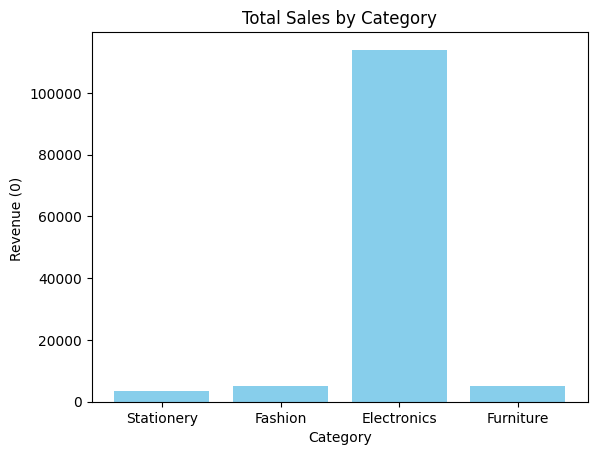

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
region_df = orders_total_df.groupBy("category").sum("total_price").toPandas()
plt.bar(region_df["category"], region_df["sum(total_price)"], color="skyblue")
plt.title("Total Sales by Category")
plt.xlabel("Category")
plt.ylabel("Revenue (0) ")


plt.show()